In [1]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
%matplotlib inline
import inspect

import warnings
warnings.filterwarnings('ignore')

In [2]:
# typical steps in ML
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


In [3]:
# parameter selection with preprocessing
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'gamma': 1, 'C': 1}


In [4]:
# building pipelines
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


In [5]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


In [6]:
# convenient pipeline creation with make_pipeline
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

print("-"*50)
      
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]
--------------------------------------------------
Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [7]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


In [8]:
# accessing attributes in a pipeline inside GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best estimator:\n{}".format(grid.best_estimator_))

print("-"*50)

print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

print("-"*50)

print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
--------------------------------------------------
Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
--------------------------------------------------
Logistic regression coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777

Best parameters: {'ridge__alpha': 10, 'polynomialfeatures__degree': 2}
Test-set score: 0.77


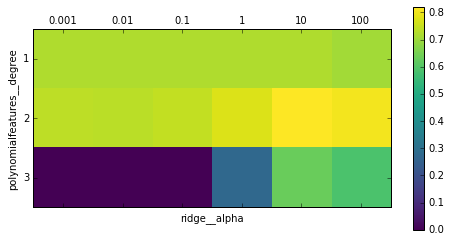

In [9]:
# grid-searching preprocessing steps and model parameters
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar()

print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

In [10]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


In [11]:
# grid-searching which model to use
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier__C': 10, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier__gamma': 0.01, 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)}

Best cross-validation score: 0.99
Test-set score: 0.98
